In [57]:
from fatiando.gravmag import normal_gravity
from fatiando.vis import mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [64]:
from icgem import load_icgem_gdf

In [76]:
dados = load_icgem_gdf('eigen-6c4-grav-ell2.gdf')


In [77]:
dados

{'area': [-14.681837, -14.671837, 319.088837, 324.153837],
 'gravity_ell': array([ 976813.89841636,  976814.60924932,  976815.3324105 , ...,
         976805.34993053,  976805.39971343,  976805.44432356]),
 'height': array([ 5000.,  5000.,  5000., ...,  5000.,  5000.,  5000.]),
 'latitude': array([-14.6818, -14.6818, -14.6818, ..., -14.6718, -14.6718, -14.6718]),
 'longitude': array([ 319.0888,  319.0938,  319.0988, ...,  324.1438,  324.1488,
         324.1538]),
 'metadata': 'generating_institute     gfz-potsdam\n     generating_date     2015/10/16\n        product_type     gravity_field\n                body     earth\n           modelname     eigen-6c4\n     max_used_degree          2190\n         tide_system     tide_free\n          functional     gravity_ell  (centrifugal term included)\n                unit     mgal\n          refsysname     WGS84\n            gmrefpot      3.98600441800E+14 m**3/s**2\n        radiusrefpot     6378137.000 m\n          flatrefpot      3.35281066474

In [73]:
lon, lat, height, gravity = dados['longitude'], dados['latitude'], dados['height'], dados['gravity_ell']

In [84]:
height.shape

(3042,)

In [88]:
dados = load_icgem_gdf('eigen-6c4-topo2.gdf')

In [89]:
dados

{'area': [-14.681837, -14.671837, 319.088837, 324.153837],
 'latitude': array([-14.681837, -14.681837, -14.681837, ..., -14.671837, -14.671837,
        -14.671837]),
 'longitude': array([ 319.088837,  319.093837,  319.098837, ...,  324.143837,
         324.148837,  324.153837]),
 'metadata': 'generating_institute     gfz-potsdam\n     generating_date     2015/10/16\n        product_type     topography\n                body     earth\n           modelname     etopo1_bin_int\n          functional     topography_grd (grid)=>bi-linear interpolation\n                unit     meter\n          refsysname     WGS84\n        radiusrefsys     6378137.000 m\n          flatrefsys      3.352810664747480E-03   (1/298.25722356300)\n       long_lat_unit     degree\n      latlimit_north      -14.671837000000    \n      latlimit_south      -14.681837000000    \n      longlimit_west       319.08883700000    \n      longlimit_east       324.15383700000    \n            gridstep      0.50000000000000E-02\n

In [90]:
topo = dados['topography_grd']

In [63]:

lon, lat, height, gravity = np.loadtxt('eigen-6c4-grav-ell.gdf', skiprows=34,
                                       unpack=True)
topo = np.loadtxt('eigen-6c4-topo.gdf', skiprows=29, usecols=[-1], unpack=True)
shape = (2, 1014)

area = (lon.min(), lon.max(), lat.min(), lat.max())

ValueError: need more than 3 values to unpack

In [91]:
# First, lets calculate the gravity disturbance (e.g., the free-air anomaly)
# We'll do this using the closed form of the normal gravity for the WGS84
# ellipsoid
gamma = normal_gravity.gamma_closed_form(lat, height)
disturbance = gravity - gamma

In [92]:
# Now we can remove the effect of the Bouguer plate to obtain the Bouguer
# anomaly. We'll use the standard densities of 2.67 g.cm^-3 for crust and 1.04
# g.cm^-3 for water.
bouguer = disturbance - normal_gravity.bouguer_plate(topo)

In [94]:
topo_positive = topo[topo >= 0]
topo_negative = topo[topo < 0]

In [95]:
jacobian = np.zeros([len(bouguer),2])
jacobian[topo < 0, 0] = topo_negative
jacobian[topo >= 0, 1] = topo_positive

In [96]:
y = bouguer

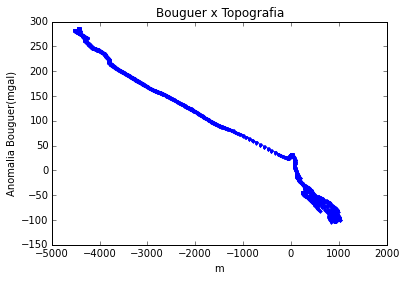

In [93]:
plt.figure()
plt.plot(topo,bouguer,'.')
plt.title('Bouguer x Topografia')
plt.xlabel('m')
plt.ylabel('Anomalia Bouguer(mgal)')

### Cálculo do parâmetro por mínimos quadrados

In [97]:
a_est = np.dot(np.dot(np.linalg.inv(np.dot(jacobian.transpose(),jacobian)),jacobian.transpose()),y)
print('a estimado=',a_est)

('a estimado=', array([-0.06052397, -0.09904182]))


### Cálculo do parâmetro por mínimos quadrados reponderado

In [98]:
result=[]
weight = np.eye(len(y),len(y))
for i in range(10):
    aest = np.dot(np.dot(np.linalg.inv(np.dot(jacobian.transpose(),np.dot(weight,jacobian))),jacobian.transpose()),np.dot(weight,y))
    result.append(aest)
    weight = np.zeros([len(y),len(y)])
    np.fill_diagonal(weight,1./((y - np.dot(jacobian,aest))**2)**0.5)

In [99]:
result

[array([-0.06052397, -0.09904182]),
 array([-0.06039787, -0.09902636]),
 array([-0.06034798, -0.09899385]),
 array([-0.06032736, -0.0989821 ]),
 array([-0.06029652, -0.09895742]),
 array([-0.06027748, -0.09894607]),
 array([-0.06025869, -0.09892771]),
 array([-0.06024624, -0.09890362]),
 array([-0.06024098, -0.09887692]),
 array([-0.06023305, -0.09884892])]